In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm.notebook import tqdm
import tensorflow as tf

import seaborn as sns
sns.color_palette("hls", 17)
import scipy.stats as st
import math

from pingouin import rcorr
import pingouin as pg
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, plot_roc_curve, roc_curve, auc, roc_auc_score,precision_recall_curve, hamming_loss, multilabel_confusion_matrix


from sklearn import feature_selection #import chi2

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [2]:
import sys
import os
sys.path.append('../')
from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [3]:
test_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_full_test.csv')).drop(["Unnamed: 0"], axis=1)
train_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_full_train.csv')).drop(["Unnamed: 0"], axis=1)
val_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_full_val.csv')).drop(["Unnamed: 0"], axis=1)

In [4]:
predictors = ["TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED",
              "ACRES",  "WF_FSR", "INJURIES", "FATALITIES", "EST_IM_COST_TO_DATE", "STR_DAMAGED",
              "STR_DESTROYED", "NEW_ACRES", "EVACUATION_IN_PROGRESS", 
              "NUM_REPORTS", "DAYS_BURING", #'Combined_Text', 
              'Incident_region_AICC', 
              'Incident_region_CA', 'Incident_region_EACC','Incident_region_GBCC', 'Incident_region_HICC', 
              'Incident_region_NRCC','Incident_region_NWCC', 'Incident_region_RMCC', 'Incident_region_SACC',
              'Incident_region_SWCC', 'INC_MGMT_ORG_ABBREV_1', 'INC_MGMT_ORG_ABBREV_2','INC_MGMT_ORG_ABBREV_3', 
              'INC_MGMT_ORG_ABBREV_4','INC_MGMT_ORG_ABBREV_5', 'INC_MGMT_ORG_ABBREV_B','INC_MGMT_ORG_ABBREV_C', 
              'INC_MGMT_ORG_ABBREV_D','INC_MGMT_ORG_ABBREV_E', 'INC_MGMT_ORG_ABBREV_F']
targets = ["Traffic","Command_Transitions","Evacuations", "Inaccurate_Mapping", "Aerial_Grounding", 
           "Resource_Issues", "Injuries", "Cultural_Resources","Livestock", "Law_Violations", "Military_Base", 
           "Infrastructure", "Extreme_Weather", "Ecological", "Hazardous_Terrain", "Floods", "Dry_Weather"]

# Prepare the Data

In [5]:
def remove_quote_marks(word_list):
    word_list = word_list.strip("[]").split(", ")
    word_list = [w.replace("'","") for w in word_list]
    word_list = " ".join(word_list)
    return word_list

In [6]:
dfs = [train_data, val_data, test_data]
for df in dfs:
    cleaned_combined_text = []
    for text in df['Combined_Text']:
        cleaned_text = remove_quote_marks(text)
        cleaned_combined_text.append(cleaned_text)
    df['Combined_Text'] = cleaned_combined_text

In [7]:
Xtrain = train_data['Raw_Combined_Text']; ytrain = train_data[targets]
Xval = val_data['Raw_Combined_Text']; yval = val_data[targets]
Xtest = test_data['Raw_Combined_Text']; ytest = test_data[targets]

# Vectorize the data

In [8]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Xtrain_vec = embed(Xtrain)
Xval_vec = embed(Xval)
Xtest_vec = embed(Xtest)

In [9]:
Xtest_vec.shape

TensorShape([4710, 512])

In [26]:
print("Training:", len(train_data['INCIDENT_ID'].unique()), len(train_data))
print("Test:", len(test_data['INCIDENT_ID'].unique()), len(test_data))
print("Val:", len(val_data['INCIDENT_ID'].unique()), len(val_data))

Training: 7177 39357
Test: 898 4710
Val: 898 4800


In [10]:
Xtest.shape

(4710,)

### Method: classifier chain
Note: classifier chains tend to perform worse on larget sets of targets. Also the performance is highly dependent on the order of the chain, so all orderings would ideally be tested.

In [11]:
classifiers = [LogisticRegression(max_iter=10000,multi_class='ovr'), RandomForestClassifier(random_state=1),
              KNeighborsClassifier(weights='distance'), MLPClassifier(random_state=1), RidgeClassifier()]
classifier_names = ['logistic regression', 'random forest', 'knn', 'MLP NN', 'Ridge']
test_hamming_loss = []; train_hamming_loss = []
test_acc = []; train_acc = []
test_f1 = []; train_f1 = []
test_precision = []; train_precision = []
test_recall = []; train_recall = []
for clf in tqdm(classifiers):
    classifier = ClassifierChain(clf)
    classifier.fit(Xtrain_vec, ytrain[targets])
    # predict
    train_preds = classifier.predict(Xtrain_vec)
    predictions = classifier.predict(Xtest_vec)
    test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
    test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
    train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
    test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
    train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
    test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
    train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
    test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
    train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    
comparison = pd.DataFrame({"Base Estimator": classifier_names,
                           "train f1": train_f1, "test f1": test_f1,
                          "train accuracy":train_acc, "test accuracy": test_acc,
                          "train recall": train_recall, "test recall": test_recall,
                          "train precision": train_precision, "test precision": test_precision,
                          "train hamming loss": train_hamming_loss, "test hamming loss": test_hamming_loss})
                    

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
comparison

,Base Estimator,train f1,test f1,train accuracy,test accuracy,train recall,test recall,train precision,test precision,train hamming loss,test hamming loss
0,logistic regression,0.335,0.164,0.424,0.405,0.243,0.122,0.642,0.272,0.098,0.105
1,random forest,1.000,0.101,1.000,0.413,1.000,0.067,1.000,0.294,0.000,0.100
2,knn,1.000,0.228,1.000,0.345,1.000,0.252,1.000,0.221,0.000,0.143
3,MLP NN,0.995,0.201,0.997,0.347,0.996,0.170,0.994,0.263,0.000,0.115
4,Ridge,0.199,0.131,0.422,0.410,0.141,0.091,0.628,0.276,0.099,0.101


### Method: multioutput classifier

### Power set label 
problem transformation to multiclass

In [11]:
ytrain['powerlabel'] = ytrain.apply(lambda x : sum([(2**i)*x[targets[i]] for i in range(len(targets))]),axis=1)
yval['powerlabel'] = yval.apply(lambda x : sum([(2**i)*x[targets[i]] for i in range(len(targets))]),axis=1)
ytest['powerlabel'] = ytest.apply(lambda x : sum([(2**i)*x[targets[i]] for i in range(len(targets))]),axis=1)
#ytrain['powerlabel'].hist(bins=np.unique(ytrain['powerlabel']))

C:\Users\srandrad\AppData\Local\Temp\2/ipykernel_5656/443457025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytrain['powerlabel'] = ytrain.apply(lambda x : sum([(2**i)*x[targets[i]] for i in range(len(targets))]),axis=1)
C:\Users\srandrad\AppData\Local\Temp\2/ipykernel_5656/443457025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yval['powerlabel'] = yval.apply(lambda x : sum([(2**i)*x[targets[i]] for i in range(len(targets))]),axis=1)
C:\Users\srandrad\AppData\Local\Temp\2/ipykernel_5656/443457

In [12]:
test_hamming_loss = []; train_hamming_loss = []
test_acc = []; train_acc = []
test_f1 = []; train_f1 = []
test_precision = []; train_precision = []
test_recall = []; train_recall = []

In [13]:
classifiers = [KNeighborsClassifier(weights='distance'),#SVC(kernel="linear", C=0.025),SVC(gamma=2, C=1),
               LinearSVC(multi_class='crammer_singer',max_iter=100000, class_weight='balanced'), DecisionTreeClassifier(),
               RandomForestClassifier(random_state=1, n_estimators=200),LogisticRegression(max_iter=10000,multi_class='multinomial'),
               MLPClassifier(alpha=1, max_iter=1000), RidgeClassifier(), AdaBoostClassifier()]
               #GaussianNB(), QuadraticDiscriminantAnalysis()]
total_names = ['Knn', #"Linear SVM", "RBF SVM",
                "Linear SVM", "Decision Tree", "Random Forest", 
                   "Logisitc Regression", 'MLP NN', 'Ridge', 'Adaboost']#, 'Gaussian NB', 'QDA']

In [14]:
for clf in tqdm(classifiers):
    classifier = clf#, n_jobs=-1)
    classifier.fit(Xtrain_vec, ytrain['powerlabel'])
    predictions = classifier.predict(Xtest_vec)
    train_preds = classifier.predict(Xtrain_vec)
    test_acc.append(round(accuracy_score(ytest['powerlabel'],predictions),3)); train_acc.append(round(accuracy_score(ytrain['powerlabel'],train_preds),3))
    test_f1.append(round(f1_score(ytest['powerlabel'],predictions, average='macro',zero_division=0),3))
    train_f1.append(round(f1_score(ytrain['powerlabel'],train_preds, average='macro',zero_division=0),3))
    test_precision.append(round(precision_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
    train_precision.append(round(precision_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
    test_recall.append(round(recall_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
    train_recall.append(round(recall_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
    test_hamming_loss.append(round(hamming_loss(ytest['powerlabel'],predictions),3))
    train_hamming_loss.append(round(hamming_loss(ytrain['powerlabel'],train_preds),3))

 12%|██████████▌                                                                         | 1/8 [00:37<04:23, 37.62s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [2:52:14<00:00, 1291.85s/it]


In [15]:
comparison = pd.DataFrame({"Model":total_names,
                           "train f1": train_f1, "test f1": test_f1,
                          "train accuracy":train_acc, "test accuracy": test_acc,
                          "train recall": train_recall, "test recall": test_recall,
                          "train precision": train_precision, "test precision": test_precision,
                          "train hamming loss": train_hamming_loss, "test hamming loss": test_hamming_loss})
comparison

,Model,train f1,test f1,train accuracy,test accuracy,train recall,test recall,train precision,test precision,train hamming loss,test hamming loss
0,Knn,1.000,0.003,1.000,0.323,1.000,0.003,1.000,0.004,0.000,0.677
1,Linear SVM,0.448,0.001,0.269,0.001,0.931,0.002,0.348,0.002,0.731,0.999
2,Decision Tree,1.000,0.001,1.000,0.257,0.999,0.001,1.000,0.001,0.000,0.743
3,Random Forest,1.000,0.003,1.000,0.413,1.000,0.004,1.000,0.002,0.000,0.587
4,Logisitc Regression,0.043,0.004,0.479,0.413,0.038,0.005,0.082,0.005,0.521,0.587
5,MLP NN,0.001,0.002,0.412,0.411,0.001,0.004,0.000,0.002,0.588,0.589
6,Ridge,0.058,0.003,0.469,0.415,0.048,0.004,0.124,0.002,0.531,0.585
7,Adaboost,0.001,0.002,0.409,0.411,0.002,0.003,0.001,0.001,0.591,0.589


### Method: One vs Rest classifier
note: this one performs better without the extreme over sampling -> maybe a simple over sampling approach is preferred here. Over fitting is definitely occuring

In [16]:
ytrain = ytrain[targets]
ytest = ytest[targets]
yval = yval[targets]

In [17]:
classifiers = [KNeighborsClassifier(weights='uniform', p=1,n_neighbors=50),SVC(kernel="linear", C=0.025),SVC(C=1,gamma='scale', break_ties=True),
               #GaussianProcessClassifier(1.0 * RBF(1.0)),
               DecisionTreeClassifier(criterion='entropy', max_features='sqrt', class_weight='balanced', splitter='best'),
               RandomForestClassifier(criterion='entropy',max_features='auto', class_weight=None, n_estimators=100),
               LogisticRegression(max_iter=10000,multi_class='ovr',solver='newton-cg', C=1),
               RidgeClassifier(alpha=1), AdaBoostClassifier(learning_rate=1), 
               XGBClassifier(booster='gbtree', n_estimators=100, max_depth=15, eval_metric='logloss',use_label_encoder=False)
              ]#GaussianNB(), QuadraticDiscriminantAnalysis()]
classifier_name = ['Knn', "Linear SVM", "RBF SVM", #"Gaussian Process",
                   "Decision Tree", "Random Forest", 
                   "Logisitc Regression", 'Ridge', 'Adaboost', 'XGBoost' ]#,'Gaussian NB', 'QDA'
                  

In [18]:
test_hamming_loss = []; train_hamming_loss = []
test_acc = []; train_acc = []
test_f1 = []; train_f1 = []
test_precision = []; train_precision = []
test_recall = []; train_recall = []

In [26]:
classifiers = [XGBClassifier(booster='gbtree', n_estimators=100, max_depth=15, eval_metric='logloss',use_label_encoder=False)]
for clf in tqdm(classifiers):
    classifier = OneVsRestClassifier(clf)#, n_jobs=-1)
    classifier.fit(Xtrain_vec.numpy(), ytrain)
    predictions = classifier.predict(Xtest_vec.numpy())
    train_preds = classifier.predict(Xtrain_vec.numpy())
    test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
    test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
    train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
    test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
    train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
    test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
    train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
    test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
    train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [26:36<00:00, 1596.63s/it]


In [27]:
comparison = pd.DataFrame({"Model":classifier_name,
                          "train f1": train_f1, "test f1": test_f1,
                          "train accuracy":train_acc, "test accuracy": test_acc,
                          "train recall": train_recall, "test recall": test_recall,
                          "train precision": train_precision, "test precision": test_precision,
                          "train hamming loss": train_hamming_loss, "test hamming loss": test_hamming_loss})

In [28]:
comparison

,Model,train f1,test f1,train accuracy,test accuracy,train recall,test recall,train precision,test precision,train hamming loss,test hamming loss
0,Knn,0.856,0.231,0.709,0.320,0.825,0.254,0.890,0.221,0.033,0.138
1,Linear SVM,0.073,0.076,0.410,0.411,0.066,0.068,0.082,0.087,0.107,0.097
2,RBF SVM,0.871,0.156,0.760,0.404,0.785,0.117,0.983,0.306,0.024,0.098
3,Decision Tree,1.000,0.172,1.000,0.168,1.000,0.184,1.000,0.167,0.000,0.161
4,Random Forest,1.000,0.124,0.999,0.411,1.000,0.086,1.000,0.289,0.000,0.099
5,Logisitc Regression,0.321,0.170,0.413,0.400,0.235,0.130,0.775,0.353,0.092,0.098
6,MLP NN,0.128,0.105,0.413,0.408,0.096,0.078,0.311,0.277,0.104,0.097
7,Ridge,0.174,0.126,0.414,0.406,0.132,0.096,0.422,0.283,0.098,0.097
8,Adaboost,0.359,0.168,0.391,0.381,0.287,0.133,0.647,0.279,0.101,0.105
9,XGBoost,1.000,0.151,1.000,0.399,1.000,0.113,1.000,0.268,0.000,0.100


# DNN

In [11]:
def build_model(features, num_neurons, drop_rate=0.5, num_layers=1, reg='dropout', LSTM=False, l1=0.01, l2=0.01, batch_norm=False, activation='tanh'):
    if activation == 'tanh':
        initializer = tf.keras.initializers.GlorotNormal()
    elif activation == 'relu':
        initializer = tf.keras.initializers.HeNormal()
    USE_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name='USE_input')
    USE_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                    trainable=True)(USE_input)
    if LSTM:
        USE_layer= tf.keras.layers.Reshape((1, 512))(USE_layer)
        USE_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=tf.keras.regularizers.l2(0.01)))(USE_layer)
    else:
        USE_output = tf.keras.layers.Dense(17, activation='sigmoid')(USE_layer)
        
    meta_input = tf.keras.layers.Input(shape=(features,), name='meta_input')
    combined_USE_meta = tf.keras.layers.Concatenate()([USE_output, meta_input])
    prev_layer = combined_USE_meta
    for i in range(num_layers):
        if batch_norm == True:
            prev_layer = tf.keras.layers.BatchNormalization()(prev_layer) # after layer before activation
        if reg == 'dropout':
            curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 #kernel_regularizer=keras.regularizers.l2(0.01),
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
            curr_layer = tf.keras.layers.Dropout(rate=drop_rate)(curr_layer)
        elif reg == 'l1':
            Curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 kernel_regularizer=tf.keras.regularizers.l1(l1),
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        elif reg =='l2':
            curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2),
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        
        prev_layer = curr_layer
    output = tf.keras.layers.Dense(17, activation='sigmoid')(prev_layer)
    model = tf.keras.Model(inputs=[USE_input , meta_input], outputs=output)
    return model


In [12]:
model = build_model(features=len(predictors), num_neurons=500, num_layers=10, LSTM=True,reg='l2', l2=0.001, activation='tanh', batch_norm=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
USE_input (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 512)          256797824   USE_input[0][0]                  
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 512)       0           keras_layer[0][0]                
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 512)          1574912     reshape[0][0]                    
______________________________________________________________________________________________

In [13]:
import tensorflow_addons as tfa
Hamming_loss=tfa.metrics.HammingLoss(mode='multilabel', threshold=0.6)

In [14]:
class_weights = {}
for c in range(len(targets)):
    class_weights[c] = ytrain.shape[0]/(2*np.count_nonzero(ytrain[targets[c]]==1))

In [15]:
mini_batch = 256
num_epochs = 10
lr = 1e-3
# First we need to define the optimizer to be used. We use Adam here with default hyper-parameters

optim = tf.keras.optimizers.Adam(learning_rate=lr)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
# We define the learning rate decay as a callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# then, we need to compile the model: this configures the model for training
model.compile(loss='categorical_crossentropy',#loss_fn,#'categorical_crossentropy',
              optimizer=optim, metrics=['accuracy',Hamming_loss])#, hamming_loss])

In [16]:
X_train = {"USE_input": Xtrain, "meta_input": np.asarray(train_data[predictors]).astype(np.float32)}
X_val = {"USE_input": Xval, "meta_input": np.asarray(val_data[predictors]).astype(np.float32)}
training = model.fit(x=X_train, y=ytrain.astype(float), batch_size=mini_batch, 
                    epochs=num_epochs, shuffle=True, verbose=0, validation_data=(X_val, yval.astype(float)),
                    class_weight=class_weights, callbacks=[reduce_lr])

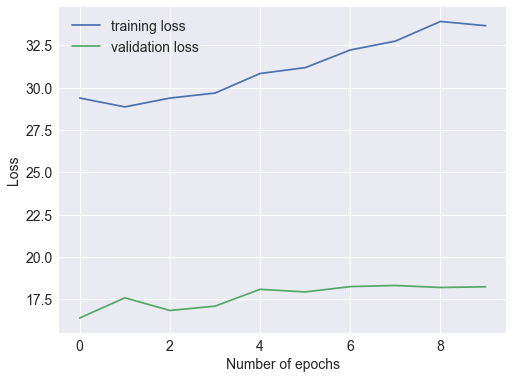

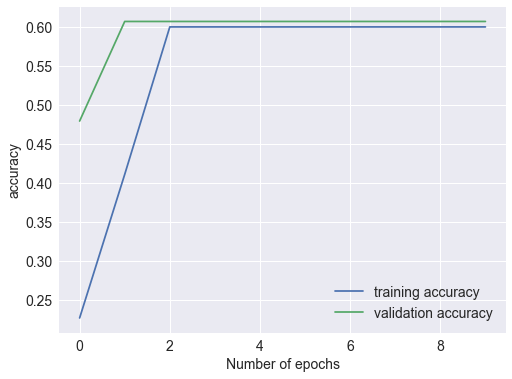

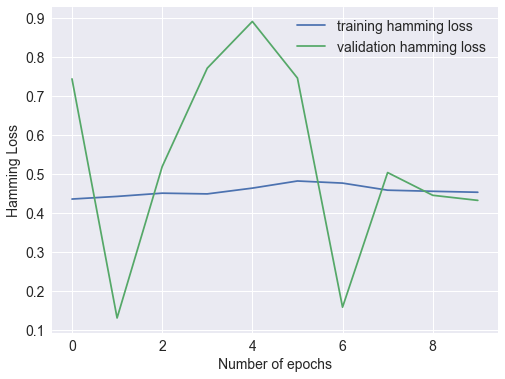

In [17]:
# plot loss and accuracy
plt.figure(figsize=(8, 6))
FONT=14
plt.plot(range(num_epochs), training.history['loss'], label='training loss')
plt.plot(range(num_epochs), training.history['val_loss'], label='validation loss')
plt.xlabel('Number of epochs', fontsize=FONT)
plt.ylabel('Loss', fontsize=FONT)
plt.legend(fontsize=FONT)
plt.tick_params(axis='both', which='major', labelsize=FONT)
plt.show()

plt.figure(figsize=(8, 6))
FONT=14
plt.plot(range(num_epochs), training.history['accuracy'], label='training accuracy')
plt.plot(range(num_epochs), training.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Number of epochs', fontsize=FONT)
plt.ylabel('accuracy', fontsize=FONT)
plt.legend(fontsize=FONT)
plt.tick_params(axis='both', which='major', labelsize=FONT)

plt.show()

plt.figure(figsize=(8, 6))
FONT=14
plt.plot(range(num_epochs), training.history['hamming_loss'], label='training hamming loss')
plt.plot(range(num_epochs), training.history['val_hamming_loss'], label='validation hamming loss')
plt.xlabel('Number of epochs', fontsize=FONT)
plt.ylabel('Hamming Loss', fontsize=FONT)
plt.legend(fontsize=FONT)
plt.tick_params(axis='both', which='major', labelsize=FONT)

plt.show()

In [18]:
test_hamming_loss = []; train_hamming_loss = []
test_acc = []; train_acc = []
test_f1 = []; train_f1 = []
test_precision = []; train_precision = []
test_recall = []; train_recall = []

Hamming loss: 0.452
Accuracy: 0.32
Detail:
              precision    recall  f1-score   support

           0       0.26      0.82      0.40       787
           1       0.52      0.86      0.65      1506
           2       0.26      0.88      0.40       729
           3       0.20      0.79      0.32       628
           4       0.07      0.83      0.13       205
           5       0.19      0.80      0.31       587
           6       0.16      0.88      0.28       461
           7       0.06      0.74      0.12       215
           8       0.01      0.68      0.03        53
           9       0.02      0.98      0.05        61
          10       0.00      0.78      0.01         9
          11       0.06      0.91      0.12       175
          12       0.28      0.83      0.41       819
          13       0.01      0.65      0.01        26
          14       0.50      0.78      0.61      1566
          15       0.04      0.82      0.08       132
          16       0.30      0.83     

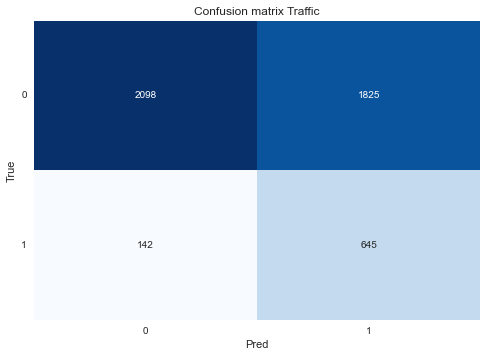

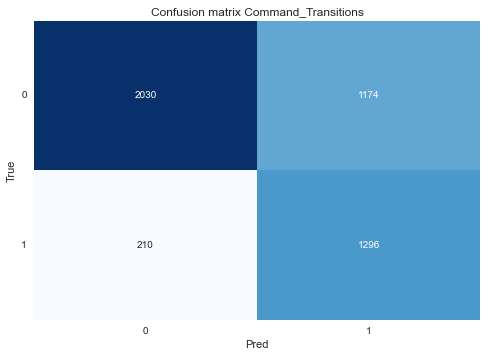

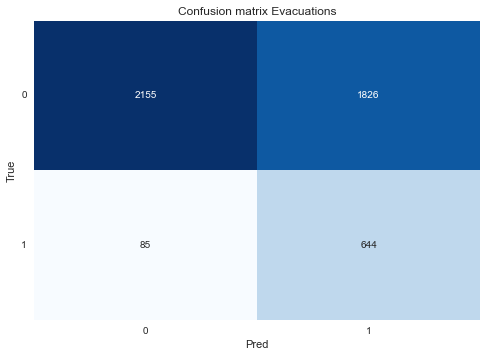

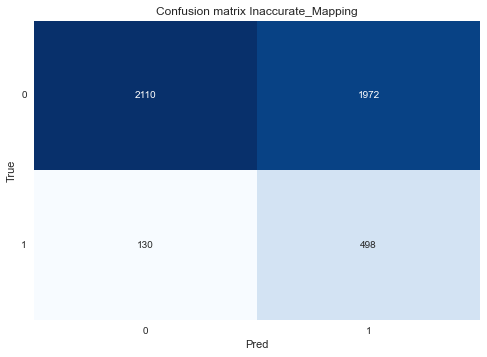

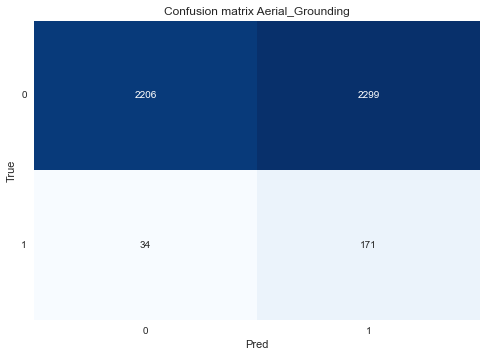

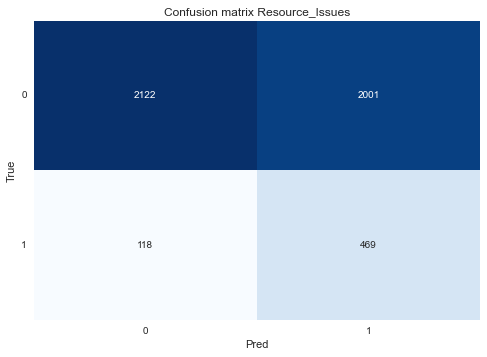

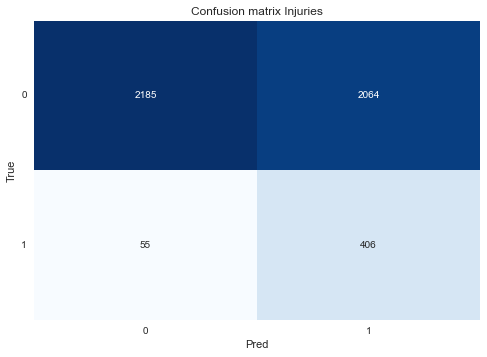

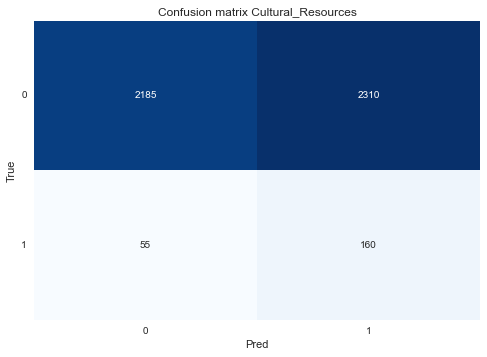

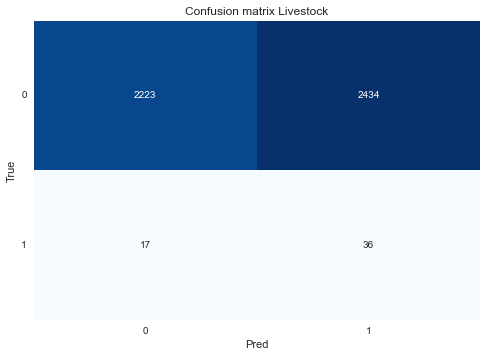

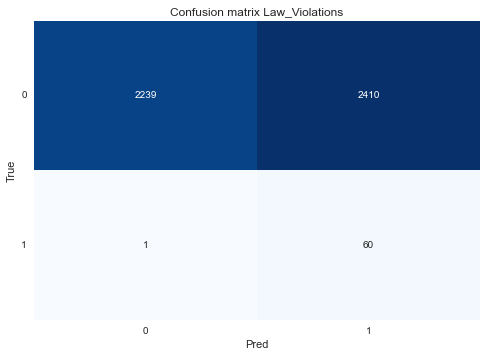

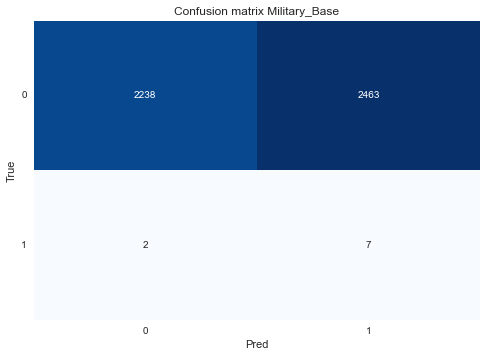

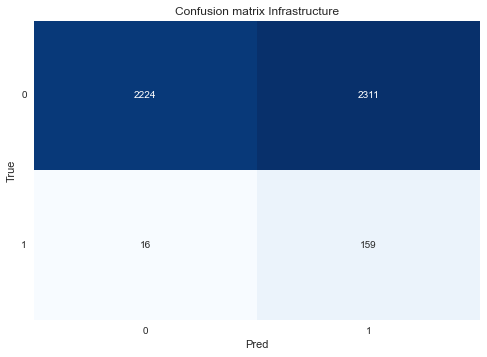

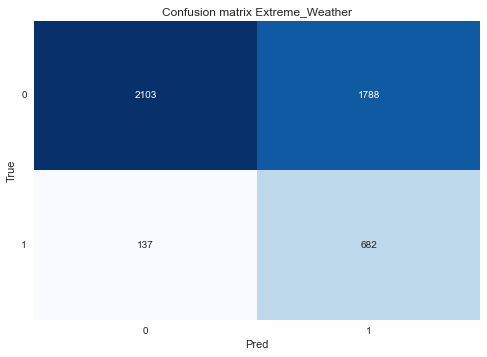

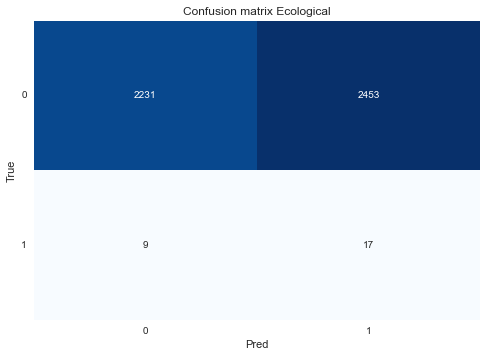

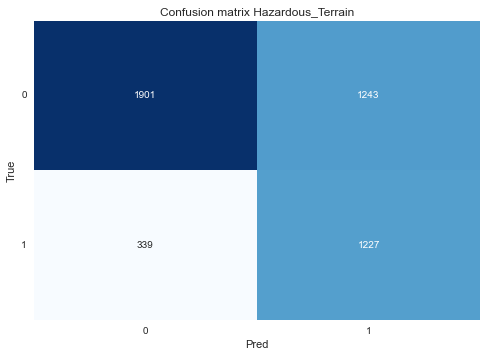

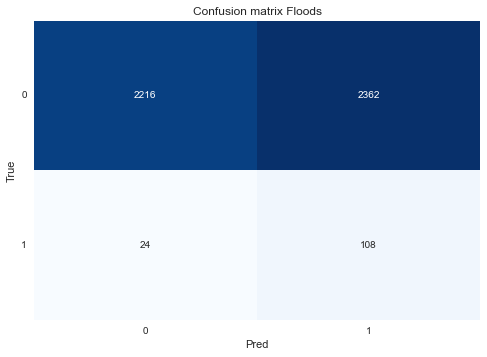

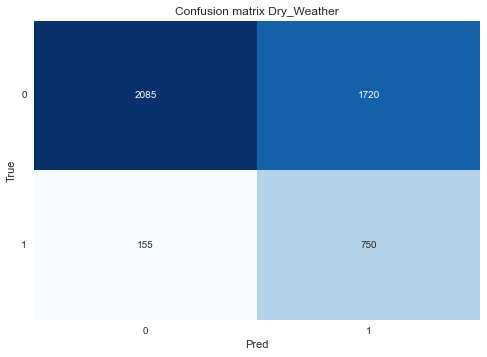

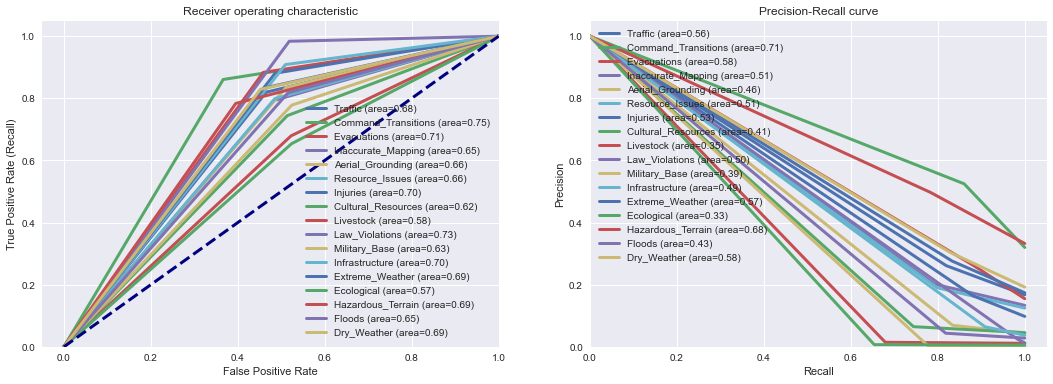

In [19]:
## test
X_test = {"USE_input": Xtest, "meta_input": np.asarray(test_data[predictors]).astype(np.float32)}
predicted_raw = model.predict(X_test)
predicted = np.around(predicted_raw)
y_test_array = ytest.to_numpy()
## Accuracy, Precision, Recall
accuracy = accuracy_score(ytest, predicted)
#auc_score = roc_auc_score(ytest, predicted, 
#                            multi_class="ovr")
print("Hamming loss:", round(hamming_loss(ytest, predicted),3))
print("Accuracy:",  round(accuracy,3))
#print("Auc:", round(auc_score,3))
print("Detail:")
print(classification_report(ytest, predicted,zero_division=0))

predictions = np.around(model.predict(X_test))
train_preds =np.around(model.predict(X_train))
test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
## Plot confusion matrix

ml_cm = multilabel_confusion_matrix(ytest.to_numpy(), predicted)
i=0
for cm in ml_cm:
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix "+targets[i])
    plt.yticks(rotation=0)
    i+=1
## Plot roc
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
for i in range(len(targets)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(targets[i], 
                              auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(targets)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(targets[i], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [20]:
comparison = pd.DataFrame({"train f1": train_f1, "test f1": test_f1,
                          "train accuracy":train_acc, "test accuracy": test_acc,
                          "train recall": train_recall, "test recall": test_recall,
                          "train precision": train_precision, "test precision": test_precision,
                          "train hamming loss": train_hamming_loss, "test hamming loss": test_hamming_loss})
comparison

,train f1,test f1,train accuracy,test accuracy,train recall,test recall,train precision,test precision,train hamming loss,test hamming loss
0,0.28,0.257,0.318,0.32,0.853,0.817,0.19,0.175,0.445,0.452


In [39]:
#model.save(os.path.join(os.path.dirname(os.getcwd()),'models','USE_hazard_classification_model'))

INFO:tensorflow:Assets written to: C:\Users\srandrad\smart_nlp\models\USE_hazard_classification_model\assets


INFO:tensorflow:Assets written to: C:\Users\srandrad\smart_nlp\models\USE_hazard_classification_model\assets


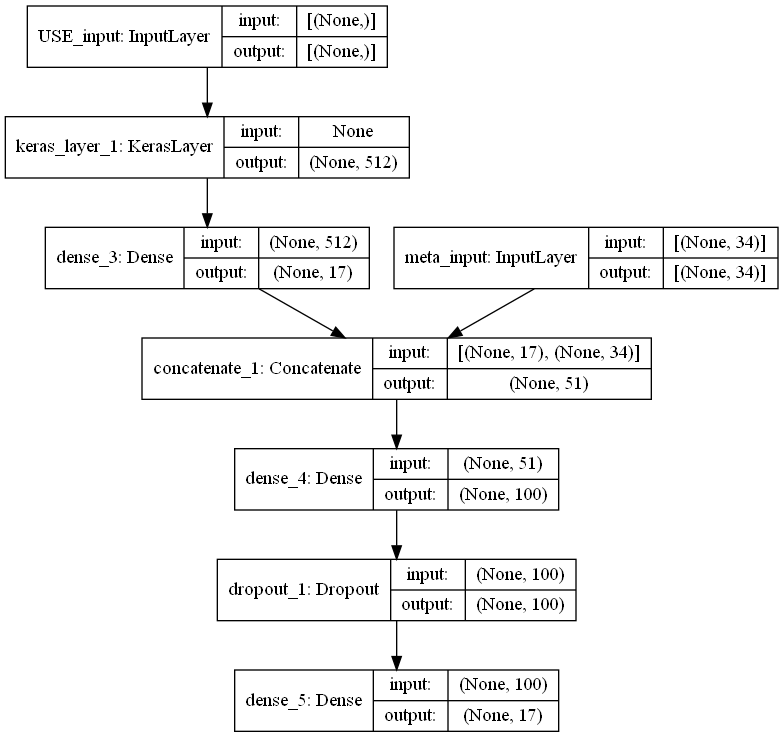

In [43]:
filename = os.path.join(os.path.dirname(os.getcwd()),'results','hazard_classification_model.png')
tf.keras.utils.plot_model(model, to_file=filename, show_shapes=True)

## Hyper parameter optimization - one vs rest

### KNN

In [24]:
params = {'n_neighbors': [50]+[i for i in range(55,1055,100)],
         #'weights':['uniform', 'distance'],
         #'p':[1,2]}
best_params = {'weights': 'uniform', 'p': 1}

In [25]:
for param in params:
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in params[param]:
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(KNeighborsClassifier(**test_params))#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

{'n_neighbors': 50, 'weights': 'uniform', 'p': 1}


### SVM

In [11]:
params = {'C': [1*(10**i) for i in range(0,2,1)],
         'class_weight':[None, "balanced"],
          'gamma': ['scale', 'auto',2],
         'break_ties':[True,False]}
best_params = {}

In [12]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(SVC(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [12:05:45<00:00, 10886.33s/it]

{'C': 1, 'class_weight': None, 'gamma': 'scale', 'break_ties': True}


In [13]:
#C=1

### Decision Tree

In [14]:
params = {'criterion':['gini', 'entropy'],
         'max_features':['auto', 'sqrt', 'log2'],
         'class_weight':[None, "balanced"],
         'splitter':['best', 'random']}
best_params = {}

In [15]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(DecisionTreeClassifier(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:55<00:00, 58.91s/it]

{'criterion': 'entropy', 'max_features': 'sqrt', 'class_weight': 'balanced', 'splitter': 'best'}


### Random Forest

In [16]:
params = {'criterion':['gini', 'entropy'],
         'max_features':['auto', 'sqrt', 'log2'],
         'class_weight':[None, "balanced"],
         'n_estimators':[i for i in range(50, 550, 50)]}
best_params = {}

In [17]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(RandomForestClassifier(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [2:17:31<00:00, 2062.94s/it]

{'criterion': 'entropy', 'max_features': 'auto', 'class_weight': None, 'n_estimators': 100}


In [18]:
rf = RandomForestClassifier(criterion='entropy',max_features='auto', class_weight='balanced', n_estimators=100)

### Logistic Regression

In [19]:
params = {'solver':['newton-cg', 'lbfgs', 'sag', 'saga'],
          'C': [i for i in range(1,11,1)],
         'class_weight':[None, "balanced"]}
best_params = {}

In [20]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(LogisticRegression(max_iter=10000,multi_class='ovr',**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [37:07<00:00, 742.53s/it]

{'solver': 'newton-cg', 'C': 1, 'class_weight': None}


### MLP

In [21]:
params = {'alpha': [1*((10)**(i)) for i in range(-4,3,1)],
         'learning_rate':['constant', 'invscaling', 'adaptive'],
          'hidden_layer_sizes':[(50,), (50,50), (50,50,50), (100,), (100,100), (100,100,100)]}
best_params = {}

In [22]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(MLPClassifier(max_iter=1000,**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [6:46:36<00:00, 8132.23s/it]

{'alpha': 0.1, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100,)}


### Ridge

In [23]:
params = {'alpha': [1*((10)**(i)) for i in range(-4,3,1)],
         'class_weight':[None, "balanced"]
         }
best_params = {}

In [24]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(RidgeClassifier(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:29<00:00, 14.77s/it]

{'alpha': 1, 'class_weight': None}


### XGBoost

In [25]:
params = {'max_depth':[None]+[i for i in range(3,25)]}#'booster': ['gbtree', 'gblinear', 'dart'], 'n_estimators': [i for i in range(100, 500, 25)]}
best_params = {'booster': 'gbtree','n_estimators':100}

In [26]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(XGBClassifier(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [7:21:59<00:00, 26519.34s/it]

{'booster': 'gbtree', 'n_estimators': 100, 'max_depth': 15}


### Adaboost

In [27]:
params = {'base_estimator':[None, DecisionTreeClassifier(criterion='entropy', max_features='sqrt', class_weight=None, splitter='best')],
          'n_estimators':[i for i in range(50, 550, 50)],
          'learning_rate':[1*((10)**(i)) for i in range(-4,2,1)]
         }
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(AdaBoostClassifier(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

 50%|█████████████████████████████████████████▌                                         | 1/2 [06:34<06:34, 394.78s/it]

In [ ]:
AdaBoostClassifier('learning_rate'=1)

## Hyper parameter optimization - classifier chain

### KNN

In [ ]:
params = {'n_neighbors': [1]+[i for i in range(5,55,5)],
         'weights':['uniform', 'distance'],
         'p':[1,2]}
best_params = {}

In [ ]:
for param in params:
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in params[param]:
        test_params = {param:val}
        test_params.update(best_params)
        classifier = ClassifierChain(KNeighborsClassifier(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### SVM

In [ ]:
params = {'C': [1*(10**i) for i in range(-4,2,1)],
         'class_weight':[None, "balanced"],
          'gamma': ['scale', 'auto',2],
         'break_ties':[True,False]}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = ClassifierChain(SVC(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### Decision Tree

In [ ]:
params = {'criterion':['gini', 'entropy'],
         'max_features':['auto', 'sqrt', 'log2'],
         'class_weight':[None, "balanced"],
         'splitter':['best', 'random']}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = ClassifierChain(DecisionTreeClassifier(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### Random Forest

In [ ]:
params = {'criterion':['gini', 'entropy'],
         'max_features':['auto', 'sqrt', 'log2'],
         'class_weight':[None, "balanced"],
         'n_estimators':[i for i in range(50, 550, 50)]}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = ClassifierChain(RandomForestClassifier(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

In [ ]:
rf = RandomForestClassifier(criterion='entropy',max_features='auto', class_weight='balanced', n_estimators=100)

### Logistic Regression

In [ ]:
params = {'solver':['newton-cg', 'lbfgs', 'sag', 'saga'],
          'C': [i for i in range(1,11,1)],
         'class_weight':[None, "balanced"]}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = ClassifierChain(LogisticRegression(max_iter=10000,multi_class='ovr',**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### MLP

In [ ]:
params = {'alpha': [1*((10)**(i)) for i in range(-4,3,1)],
         'learning_rate':['constant', 'invscaling', 'adaptive'],
          'hidden_layer_sizes':[(50,), (50,50), (50,50,50), (100,), (100,100), (100,100,100)]}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = ClassifierChain(MLPClassifier(max_iter=1000,**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### Ridge

In [ ]:
params = {'alpha': [1*((10)**(i)) for i in range(-4,3,1)],
         'class_weight':[None, "balanced"]
         }
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = ClassifierChain(RidgeClassifier(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### XGBoost

In [ ]:
params = {'max_depth':[None]+[i for i in range(3,25)]}#'booster': ['gbtree', 'gblinear', 'dart'], 'n_estimators': [i for i in range(100, 500, 25)]}
best_params = {'booster': 'gbtree','n_estimators':100}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = ClassifierChain(XGBClassifier(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### Adaboost

In [ ]:
params = {'base_estimator':[None, DecisionTreeClassifier(criterion='entropy', max_features='sqrt', class_weight=None, splitter='best')],
          'n_estimators':[i for i in range(50, 550, 50)],
          'learning_rate':[1*((10)**(i)) for i in range(-4,2,1)]
         }
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = ClassifierChain(AdaBoostClassifier(**test_params), n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

In [ ]:
AdaBoostClassifier('learning_rate'=1)

## Hyper parameter optimization - Label Powerset

### KNN

In [ ]:
params = {'n_neighbors': [1]+[i for i in range(5,55,5)],
         'weights':['uniform', 'distance'],
         'p':[1,2]}
best_params = {}

In [ ]:
for param in params:
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in params[param]:
        test_params = {param:val}
        test_params.update(best_params)
        classifier = KNeighborsClassifier(**test_params)#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain['powerlabel'])
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest['powerlabel'],predictions),3)); train_acc.append(round(accuracy_score(ytrain['powerlabel'],train_preds),3))
        test_f1.append(round(f1_score(ytest['powerlabel'],predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain['powerlabel'],train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest['powerlabel'],predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain['powerlabel'],train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### SVM

In [ ]:
params = {'C': [1*(10**i) for i in range(-4,2,1)],
         'class_weight':[None, "balanced"],
          'gamma': ['scale', 'auto',2],
         'break_ties':[True,False]}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = SVC(**test_params)#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain['powerlabel'])
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest['powerlabel'],predictions),3)); train_acc.append(round(accuracy_score(ytrain['powerlabel'],train_preds),3))
        test_f1.append(round(f1_score(ytest['powerlabel'],predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain['powerlabel'],train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest['powerlabel'],predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain['powerlabel'],train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### Decision Tree

In [ ]:
params = {'criterion':['gini', 'entropy'],
         'max_features':['auto', 'sqrt', 'log2'],
         'class_weight':[None, "balanced"],
         'splitter':['best', 'random']}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = DecisionTreeClassifier(**test_params)#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain['powerlabel'])
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest['powerlabel'],predictions),3)); train_acc.append(round(accuracy_score(ytrain['powerlabel'],train_preds),3))
        test_f1.append(round(f1_score(ytest['powerlabel'],predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain['powerlabel'],train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest['powerlabel'],predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain['powerlabel'],train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### Random Forest

In [ ]:
params = {'criterion':['gini', 'entropy'],
         'max_features':['auto', 'sqrt', 'log2'],
         'class_weight':[None, "balanced"],
         'n_estimators':[i for i in range(50, 550, 50)]}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = RandomForestClassifier(**test_params)#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain['powerlabel'])
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest['powerlabel'],predictions),3)); train_acc.append(round(accuracy_score(ytrain['powerlabel'],train_preds),3))
        test_f1.append(round(f1_score(ytest['powerlabel'],predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain['powerlabel'],train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest['powerlabel'],predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain['powerlabel'],train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

In [ ]:
rf = RandomForestClassifier(criterion='entropy',max_features='auto', class_weight='balanced', n_estimators=100)

### Logistic Regression

In [ ]:
params = {'solver':['newton-cg', 'lbfgs', 'sag', 'saga'],
          'C': [i for i in range(1,11,1)],
         'class_weight':[None, "balanced"]}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = LogisticRegression(max_iter=10000,multi_class='ovr',**test_params)#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain['powerlabel'])
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest['powerlabel'],predictions),3)); train_acc.append(round(accuracy_score(ytrain['powerlabel'],train_preds),3))
        test_f1.append(round(f1_score(ytest['powerlabel'],predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain['powerlabel'],train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest['powerlabel'],predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain['powerlabel'],train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### MLP

In [ ]:
params = {'alpha': [1*((10)**(i)) for i in range(-4,3,1)],
         'learning_rate':['constant', 'invscaling', 'adaptive'],
          'hidden_layer_sizes':[(50,), (50,50), (50,50,50), (100,), (100,100), (100,100,100)]}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = MLPClassifier(max_iter=1000,**test_params)#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain['powerlabel'])
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest['powerlabel'],predictions),3)); train_acc.append(round(accuracy_score(ytrain['powerlabel'],train_preds),3))
        test_f1.append(round(f1_score(ytest['powerlabel'],predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain['powerlabel'],train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest['powerlabel'],predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain['powerlabel'],train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### Ridge

In [ ]:
params = {'alpha': [1*((10)**(i)) for i in range(-4,3,1)],
         'class_weight':[None, "balanced"]
         }
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = RidgeClassifier(**test_params)#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain['powerlabel'])
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest['powerlabel'],predictions),3)); train_acc.append(round(accuracy_score(ytrain['powerlabel'],train_preds),3))
        test_f1.append(round(f1_score(ytest['powerlabel'],predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain['powerlabel'],train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest['powerlabel'],predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain['powerlabel'],train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### XGBoost

In [ ]:
params = {'max_depth':[None]+[i for i in range(3,25)]}#'booster': ['gbtree', 'gblinear', 'dart'], 'n_estimators': [i for i in range(100, 500, 25)]}
best_params = {'booster': 'gbtree','n_estimators':100}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = XGBClassifier(**test_params)#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain['powerlabel'])
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest['powerlabel'],predictions),3)); train_acc.append(round(accuracy_score(ytrain['powerlabel'],train_preds),3))
        test_f1.append(round(f1_score(ytest['powerlabel'],predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain['powerlabel'],train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest['powerlabel'],predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain['powerlabel'],train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### Adaboost

In [ ]:
params = {'base_estimator':[None, DecisionTreeClassifier(criterion='entropy', max_features='sqrt', class_weight=None, splitter='best')],
          'n_estimators':[i for i in range(50, 550, 50)],
          'learning_rate':[1*((10)**(i)) for i in range(-4,2,1)]
         }
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = AdaBoostClassifier(**test_params)#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain['powerlabel'])
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest['powerlabel'],predictions),3)); train_acc.append(round(accuracy_score(ytrain['powerlabel'],train_preds),3))
        test_f1.append(round(f1_score(ytest['powerlabel'],predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain['powerlabel'],train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest['powerlabel'],predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain['powerlabel'],train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

In [ ]:
AdaBoostClassifier('learning_rate'=1)